# **Description:**

Anomaly detection using an ARIMA model involves fitting the model to historical time series data to predict future values. The model's residuals (differences between actual and predicted values) are then analyzed. Anomalies are identified by setting a threshold, often based on standard deviations of these residuals. Data points where residuals exceed this threshold are considered anomalies. This approach is useful for detecting significant deviations from the expected pattern, such as unexpected spikes or drops, and can help in identifying unusual events or errors in the data.

# 1.Import Libraries

In [67]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima

# 2.Import Dataset

This dataset was imported from kaggle website. It is a daily website visitors dataset .It consists of many independent features like page loads, Unique visits, First time visits, returning visits..etc. But I want to find anomalies on Page loads

# Reference: 
https://www.kaggle.com/datasets/bobnau/daily-website-visitors

In [68]:
df=pd.read_csv('daily-website-visitors.csv')
df = df.replace(',', '', regex=True)
df=df.drop(['Row','Day'],axis=1)
columns_to_convert=['Day.Of.Week','Page.Loads','Unique.Visits','First.Time.Visits','Returning.Visits']
df[columns_to_convert] = df[columns_to_convert].astype(float)
df=df.dropna()
print(df.shape)
df.head()

(2167, 6)


,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1.0,9/14/2014,2146.0,1582.0,1430.0,152.0
1,2.0,9/15/2014,3621.0,2528.0,2297.0,231.0
2,3.0,9/16/2014,3698.0,2630.0,2352.0,278.0
3,4.0,9/17/2014,3667.0,2614.0,2327.0,287.0
4,5.0,9/18/2014,3316.0,2366.0,2130.0,236.0


Here we changed strings to int and then deleted 'Row' ,'Day'. We had also deleted rows if any NaN value present.

# 3. Check for stationarity

In [69]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print(dftest[0])
    print(dftest[1])
    print(dftest[2])
    print(dftest[3])
    for key,value in dftest[4].items():
        print('\t',key,";",value)
ad_test(df['Page.Loads'])

-4.2838214361876625
0.00047375782574651055
26
2140
	 1% ; -3.4334094211542983
	 5% ; -2.8628915360971003
	 10% ; -2.5674894918770197


We had got p-value as 0.0004737, critical values as 1% ; -3.4334094211542983, 5% ; -2.8628915360971003, 10% ; -2.5674894918770197. Which mean our dataset has stationarity and god for anomaly detection using ARIMA model

# 4. Import auto arima

In [70]:
from pmdarima import auto_arima
stepwise_fit=auto_arima(df['Page.Loads'],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=34769.696, Time=1.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37394.682, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35636.779, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=35427.113, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42444.548, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=34962.902, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=34797.573, Time=1.01 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=34816.720, Time=1.35 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=35303.433, Time=1.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34871.882, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=34706.136, Time=1.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=34739.905, Time=1.17 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=34710.218, Time=1.88 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=34766.028, Time=0.92 sec
 ARIMA(0,0,4)(0,0,0

We had got best model at order (1,0,5) with AIC=34105.378.

# 5. Split into Training and Test set

In [ ]:
train_data=df.iloc[:-30]
test_data=df.iloc[-30:]
print(train_data.shape,test_data.shape)

# 6. Build an ARIMA model

We should an ARIMA model for train dataset and with order (1,0,5)

In [71]:
from statsmodels.tsa.arima.model import ARIMA
train_data=df.iloc[:-30]
test_data=df.iloc[-30:]
print(train_data.shape,test_data.shape)
model=ARIMA(train_data['Page.Loads'],order=(1,0,5))


(2137, 6) (30, 6)


In [72]:
model=model.fit()

c:\Users\tejat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Summary of ARIMA model**

In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Page.Loads   No. Observations:                 2137
Model:                 ARIMA(1, 0, 5)   Log Likelihood              -16788.491
Date:                Tue, 03 Sep 2024   AIC                          33592.982
Time:                        16:59:31   BIC                          33638.319
Sample:                             0   HQIC                         33609.573
                               - 2137                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4128.7257   2836.130      1.456      0.145   -1429.986    9687.438
ar.L1          0.9971      0.005    186.723      0.000       0.987       1.008
ma.L1          0.1752      0.018      9.499      0.000       0.139       0.211
ma.L2         -0.8414      0.017    -49.991      0.000      -0.874      -0.808
ma.L3         -0.6685      0.020    -33.039      0.000      -0.708      -0.629
ma.L4          0.3501      0.017     21.078      0.000       0.318       0.383
ma.L5          0.5737      0.019     30.265      0.000       0.537       0.611
sigma2      3.907e+05   1.32e+04     29.685      0.000    3.65e+05    4.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                10.97
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.16
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 7. Predict results for test dataset

In [74]:
pred=model.predict(start=len(train_data),end=len(train_data+test_data)-1,typ='levels')
print(pred)

2137    4143.367933
2138    3518.651113
2139    3055.157359
2140    3037.509643
2141    3109.073347
2142    3112.065036
2143    3115.047947
2144    3118.022107
2145    3120.987540
2146    3123.944272
2147    3126.892329
2148    3129.831737
2149    3132.762520
2150    3135.684704
2151    3138.598315
2152    3141.503377
2153    3144.399915
2154    3147.287955
2155    3150.167521
2156    3153.038638
2157    3155.901332
2158    3158.755626
2159    3161.601546
2160    3164.439116
2161    3167.268360
2162    3170.089303
2163    3172.901969
2164    3175.706383
2165    3178.502569
2166    3181.290551
Name: predicted_mean, dtype: float64


c:\Users\tejat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


# 8. Plot predictions and true values

3272.266666666667

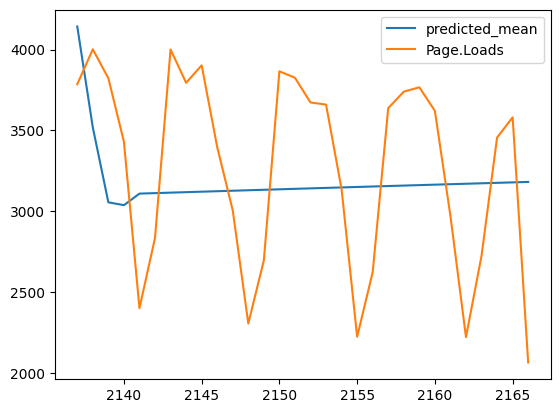

In [75]:
pred.plot(legend=True)
test_data['Page.Loads'].plot(legend=True)
test_data['Page.Loads'].mean()

The graph looks that our model predicted with less accuracy but it's ok that we are just predicting anomalies.

# 9. Evaluate metrics

In [76]:
import math
from sklearn.metrics import mean_squared_error
rmse=math.sqrt(mean_squared_error(pred,test_data['Page.Loads']))
print(rmse)

604.6941705224817


We had got rmse of 604 and mean of 3272. 604/3272 which is approximately 18.5% . This may not meet requirements but its good as comapred to our data.

# 10. Set Threshold to detect anomalies

In [77]:
residuals=test_data['Page.Loads']-pred
threshold=1.0*residuals.std()
anomalies=residuals[abs(residuals)>threshold]
print('Anomalies Detected:')
print(anomalies)

Anomalies Detected:
2139     767.842641
2141    -709.073347
2143     885.952053
2144     676.977893
2145     782.012460
2148    -824.831737
2150     730.315296
2151     687.401685
2155    -927.167521
2162    -949.089303
2166   -1117.290551
dtype: float64


We had set some threshold and observed which samples have very large difference in predicted and true values

# 11.Plot Anomalies 

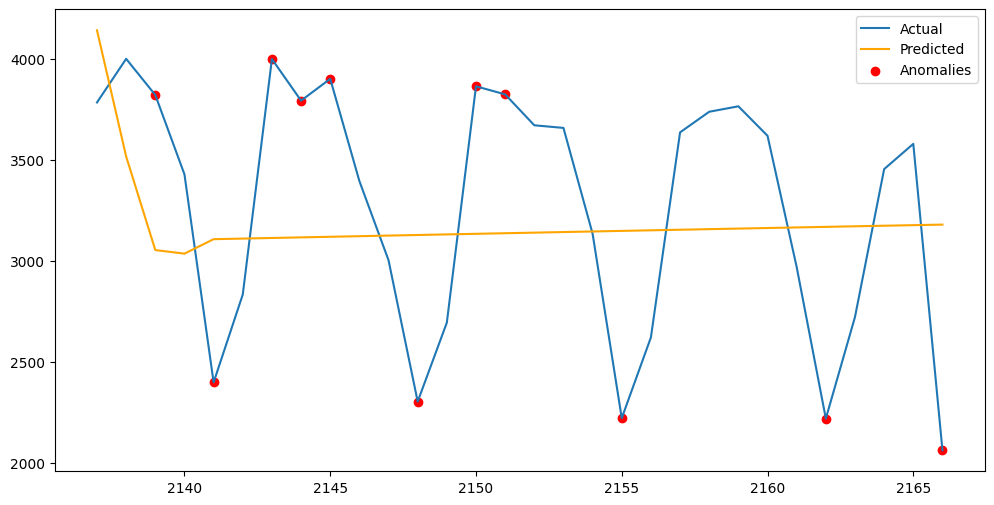

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Page.Loads'], label='Actual')
plt.plot(test_data.index, pred, label='Predicted', color='orange')
plt.scatter(anomalies.index, test_data.loc[anomalies.index, 'Page.Loads'], color='red', label='Anomalies')
plt.legend()
plt.show()


The red dots are anomalies for the dataset with pag loads column.